In [33]:

# Load essential libraries for data manipulation, visualization, and processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import zscore
import numpy as np


In [35]:

# Load dataset from CSV file and inspect the first few rows
data = pd.read_csv('appartements_data1.csv')
data.head()


,title,price,location,type_de_vente,salon,chamber,toilete,area,link
0,Appartement location de vacances à Meknès,300 DH /Nuit,Meknès,NaN,NaN,NaN,NaN,NaN,https://www.avito.ma/fr/autre_secteur/location...
1,appartement à louer,2 400 DH,Casablanca,NaN,1.0,NaN,NaN,50.0,https://www.avito.ma/fr/al_qods/appartements/a...
2,Appartement beru à louer 150 m² à Temara,6 500 DH,Temara,NaN,1.0,NaN,NaN,150.0,https://www.avito.ma/fr/autre_secteur/appartem...
3,Appartement près a casanearshor sidi maarouf,3 000 DH,Casablanca,NaN,1.0,NaN,NaN,56.0,https://www.avito.ma/fr/sidi_maarouf/apparteme...
4,Appartement 84 m²Al Baraka à Dcheïra El Jihadia,701 720 DH,Dcheïra El Jihadia,"Appartements, à vendre",1.0,3.0,2.0,84.0,https://www.avito.ma/fr/dche%C3%AFra_el_jihadi...


In [37]:

# Create a summary of each column: data types, non-null counts, and missing value percentages
data_summary = pd.DataFrame({
    "Column": data.columns,
    "Data Type": data.dtypes,
    "Non-Null Count": data.notnull().sum(),
    "Percentage Missing": data.isnull().mean() * 100
})
data_summary


,Column,Data Type,Non-Null Count,Percentage Missing
title,title,object,1062,0.094073
price,price,object,930,12.511759
location,location,object,1062,0.094073
type_de_vente,type_de_vente,object,386,63.687676
salon,salon,float64,640,39.793039
chamber,chamber,float64,339,68.109125
toilete,toilete,float64,336,68.391345
area,area,float64,693,34.807150
link,link,object,1063,0.000000


C:\Users\Youcode\AppData\Local\Temp\ipykernel_23244\712241218.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.index, y=missing_pct, palette="coolwarm")


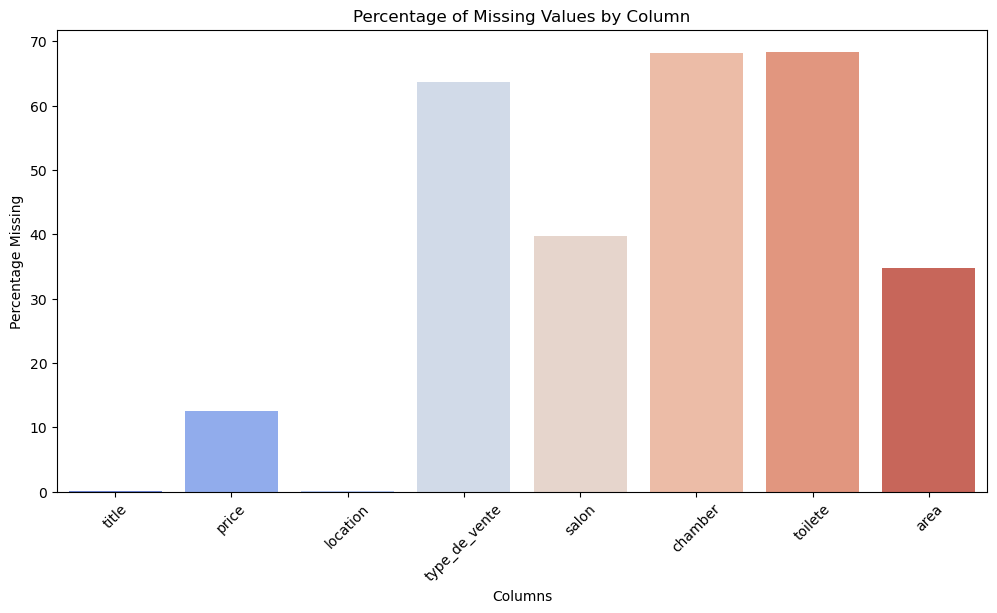

In [39]:

# Plot missing data percentages for better understanding of missing values in each column
missing_pct = data.isnull().mean() * 100
missing_pct = missing_pct[missing_pct > 0]

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct.index, y=missing_pct, palette="coolwarm")
plt.title("Percentage of Missing Values by Column")
plt.xlabel("Columns")
plt.ylabel("Percentage Missing")
plt.xticks(rotation=45)
plt.show()


In [40]:

# Remove non-numeric characters from 'price' (e.g., "DH") and convert to numeric values
data['price_numeric'] = data['price'].str.replace(r'[^\d.]', '', regex=True).astype(float)
data[['price', 'price_numeric']].head()


,price,price_numeric
0,300 DH /Nuit,300.0
1,2 400 DH,2400.0
2,6 500 DH,6500.0
3,3 000 DH,3000.0
4,701 720 DH,701720.0


In [43]:

# Replace missing values in numeric columns with the median, which is less affected by outliers
for column in ['salon', 'chamber', 'toilete', 'area']:
    data[column].fillna(data[column].median(), inplace=True)

# Use KNN for more precise imputation in 'price_numeric'
imputer = KNNImputer(n_neighbors=5)
data[['price_numeric']] = imputer.fit_transform(data[['price_numeric']])


C:\Users\Youcode\AppData\Local\Temp\ipykernel_23244\3305916380.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)


In [45]:

# Function to determine 'type_de_vente' using keywords found in 'title'
def deduce_sale_type(text):
    text = str(text).lower()
    if any(word in text for word in ["louer", "location", "loué"]):
        return "rent"
    elif any(word in text for word in ["vendre", "vente", "à vendre"]):
        return "sale"
    return None

# Apply the function to populate 'type_de_vente' based on title content
data['type_de_vente'] = data.apply(
    lambda row: row['type_de_vente'] if pd.notnull(row['type_de_vente']) else deduce_sale_type(row['title']),
    axis=1
)
data['type_de_vente'].fillna("unknown", inplace=True)
data['type_de_vente'].value_counts()


C:\Users\Youcode\AppData\Local\Temp\ipykernel_23244\203185828.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['type_de_vente'].fillna("unknown", inplace=True)


type_de_vente
unknown                   394
Appartements, à vendre    386
rent                      275
sale                        8
Name: count, dtype: int64

In [47]:

# Detect outliers in 'price_numeric' using Z-score: values far from the mean (±3 standard deviations)
data['price_z'] = zscore(data['price_numeric'])
price_outliers = data[(data['price_z'] > 3) | (data['price_z'] < -3)]
print("Outliers in 'price_numeric':", len(price_outliers))


Outliers in 'price_numeric': 8


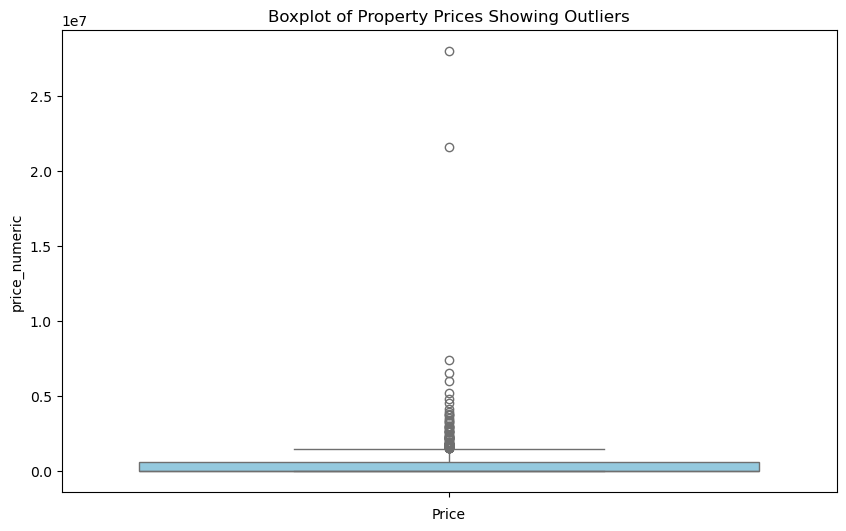

In [49]:

# Use a boxplot to visualize outliers in 'price_numeric'
plt.figure(figsize=(10, 6))
sns.boxplot(data['price_numeric'], color="skyblue")
plt.title("Boxplot of Property Prices Showing Outliers")
plt.xlabel("Price")
plt.show()


Outliers in 'area': 109


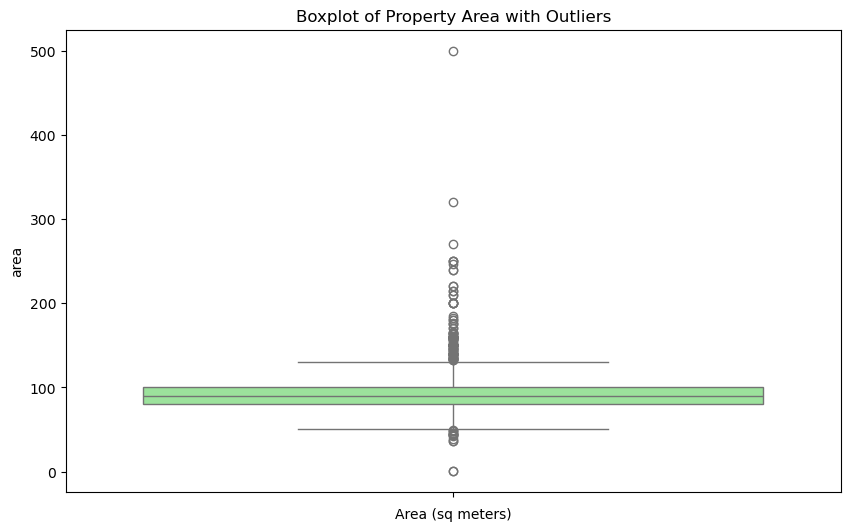

In [50]:

# Calculate Interquartile Range (IQR) for 'area' and detect outliers based on spread
Q1 = data['area'].quantile(0.25)
Q3 = data['area'].quantile(0.75)
IQR = Q3 - Q1
area_outliers = data[(data['area'] < (Q1 - 1.5 * IQR)) | (data['area'] > (Q3 + 1.5 * IQR))]
print("Outliers in 'area':", len(area_outliers))

# Visualize area with a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data['area'], color="lightgreen")
plt.title("Boxplot of Property Area with Outliers")
plt.xlabel("Area (sq meters)")
plt.show()


In [52]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardize 'price_numeric' and 'area' to have mean=0 and std=1
scaler = StandardScaler()
data[['std_price', 'std_area']] = scaler.fit_transform(data[['price_numeric', 'area']])

# Normalize 'price_numeric' and 'area' between 0 and 1 for consistent range
normalizer = MinMaxScaler()
data[['norm_price', 'norm_area']] = normalizer.fit_transform(data[['price_numeric', 'area']])
data[['price_numeric', 'std_price', 'norm_price', 'area', 'std_area', 'norm_area']].head()


,price_numeric,std_price,norm_price,area,std_area,norm_area
0,300.0,-0.374968,0.000005,90.0,-0.144840,0.178357
1,2400.0,-0.373363,0.000080,50.0,-1.360754,0.098196
2,6500.0,-0.370229,0.000227,150.0,1.679030,0.298597
3,3000.0,-0.372904,0.000102,56.0,-1.178367,0.110220
4,701720.0,0.161227,0.025056,84.0,-0.327227,0.166333


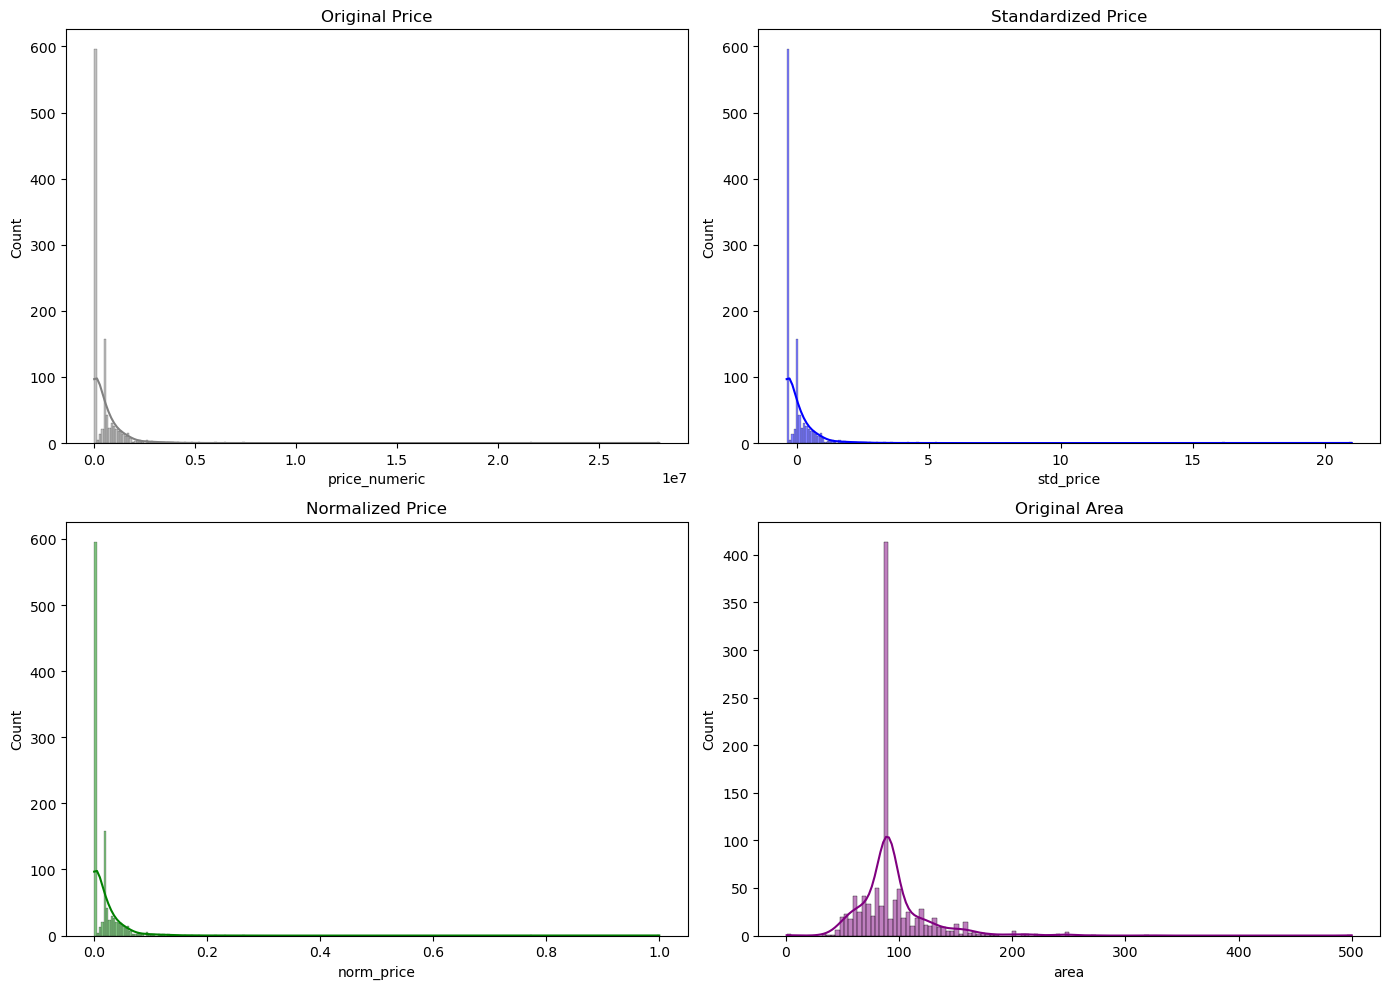

In [55]:

# Plot distributions to compare original, standardized, and normalized data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(data['price_numeric'], kde=True, ax=axes[0, 0], color="grey").set(title='Original Price')
sns.histplot(data['std_price'], kde=True, ax=axes[0, 1], color="blue").set(title='Standardized Price')
sns.histplot(data['norm_price'], kde=True, ax=axes[1, 0], color="green").set(title='Normalized Price')
sns.histplot(data['area'], kde=True, ax=axes[1, 1], color="purple").set(title='Original Area')
plt.tight_layout()
plt.show()


In [56]:

from imblearn.over_sampling import SMOTE

# Convert 'type_de_vente' to numerical codes for SMOTE
data['sale_type_code'] = data['type_de_vente'].astype('category').cat.codes

# Balance classes with SMOTE to address any imbalance in 'sale_type_code'
smote = SMOTE(random_state=42)
features = data[['std_price', 'std_area', 'salon', 'chamber', 'toilete']]
target = data['sale_type_code']
balanced_features, balanced_target = smote.fit_resample(features, target)

# Check class distribution after SMOTE
pd.Series(balanced_target).value_counts()


sale_type_code
1    394
3    394
0    394
2    394
Name: count, dtype: int64

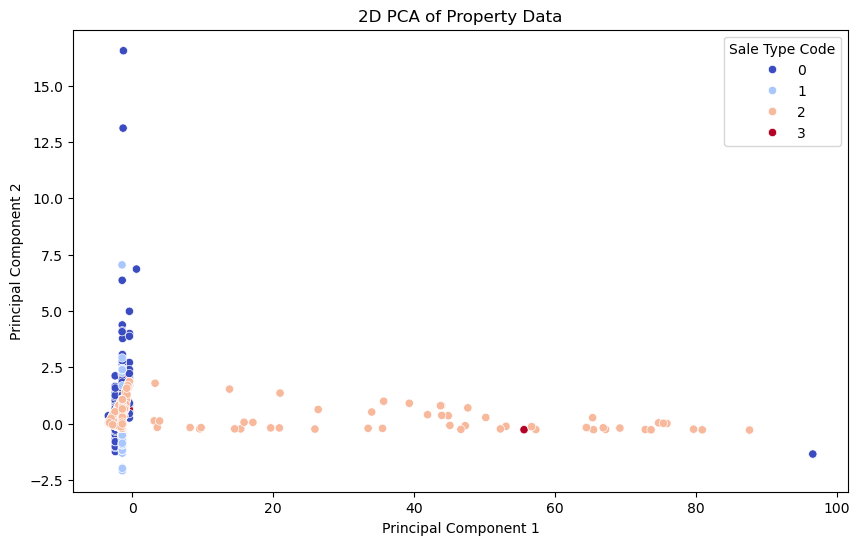

In [57]:

from sklearn.decomposition import PCA

# Reduce data to 2 principal components with PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(balanced_features)

# Create a DataFrame for PCA and plot
pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['sale_type_code'] = balanced_target

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='sale_type_code', palette='coolwarm')
plt.title("2D PCA of Property Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Sale Type Code')
plt.show()
